<a href="https://www.kaggle.com/code/muichimon/nanovlm-on-synthetic-dataset?scriptVersionId=293144478" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Imports**

In [1]:
#@title Imports

import math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Creating Synthetic Dataset**

In [3]:
#@title Synthetic Dataset Properties

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray']
shapes = ['square', 'circle', 'triangle']
positions = ['left', 'center', 'right', 'top', 'bottom', 'top-left', 'top-right', 'bottom-left', 'bottom-right']

In [4]:
def draw_sample(color:str, shape:str, position:str, img_size:int=64, shape_size:int=20) -> Image:
    """
    Draws a colored shape at a specified position and returns a PIL image.
    """

    # Create blank white image
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    # Define position coordinates
    pos_map = {
        "center": (img_size // 2, img_size // 2),
        "left": (shape_size, img_size // 2),
        "right": (img_size - shape_size, img_size // 2),
        "top": (img_size // 2, shape_size),
        "bottom": (img_size // 2, img_size - shape_size),
        "top-left": (shape_size, shape_size),
        "top-right": (img_size - shape_size, shape_size),
        "bottom-left": (shape_size, img_size - shape_size),
        "bottom-right": (img_size - shape_size, img_size - shape_size),
    }

    cx, cy = pos_map[position]

    if shape == "circle":
        draw.ellipse(
            [cx - shape_size, cy - shape_size, cx + shape_size, cy + shape_size],
            fill=color
        )

    elif shape == "square":
        draw.rectangle(
            [cx - shape_size, cy - shape_size, cx + shape_size, cy + shape_size],
            fill=color
        )

    elif shape == "triangle":
        points = [
            (cx, cy - shape_size),
            (cx - shape_size, cy + shape_size),
            (cx + shape_size, cy + shape_size),
        ]
        draw.polygon(points, fill=color)

    else:
        raise ValueError("Unsupported shape")

    return img

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

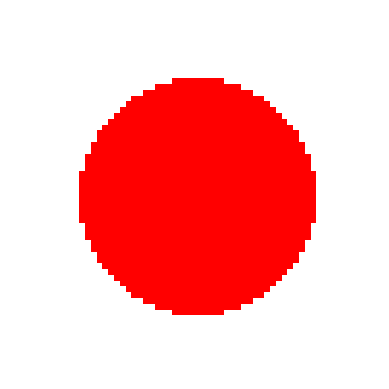

In [5]:
img = draw_sample("red", "circle", "center")
plt.imshow(img)
plt.axis("off")

## **dataset**

In [6]:
from typing import List, Tuple # for type hinting the functions

class ShapesDataset(Dataset):
    def __init__(self) -> None:
        self.images: List[torch.Tensor] = []
        self.captions: List[str] = []

        for c in colors:
            for s in shapes:
                for p in positions:
                    img: Image.Image = draw_sample(c, s, p)
                    caption: str = f"{c} {s} {p}"

                    img_np = np.array(img, copy=True)
                    img_tensor = (
                        torch.from_numpy(img_np)
                        .permute(2, 0, 1)
                        .float()
                        / 255.0
                    )

                    self.images.append(img_tensor)
                    self.captions.append(caption)

        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts: List[str]) -> Tuple[List[str], dict[str, int]]:
        words: List[str] = sorted({w for t in texts for w in t.split()})
        vocab: List[str] = ["[CLS]"] + words
        word2idx: dict[str, int] = {w: i for i, w in enumerate(vocab)}
        return vocab, word2idx

    def encode_text(self, text: str) -> torch.Tensor:
        tokens: List[int] = (
            [self.word2idx["[CLS]"]] +
            [self.word2idx[w] for w in text.split()]
        )
        return torch.tensor(tokens, dtype=torch.long)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image: torch.Tensor = self.images[idx]
        caption_str: str = self.captions[idx]
        caption_tensor: torch.Tensor = self.encode_text(caption_str)
        return image, caption_tensor, caption_str

In [7]:
shapes_ds = ShapesDataset()
print(f"Size of Dataset: {len(shapes_ds)}")

Size of Dataset: 243


In [8]:
VOCAB_SIZE = len(shapes_ds.vocab)
print(f"VOCAB_SIZE: {VOCAB_SIZE}")
print(shapes_ds.vocab)

VOCAB_SIZE: 22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


## **dataloader**

In [9]:
from torch.utils.data import random_split

train_size = int(0.8 * len(shapes_ds))
val_size = len(shapes_ds) - train_size

generator = torch.Generator().manual_seed(42)

train_ds, val_ds = random_split(
    shapes_ds,
    [train_size, val_size],
    generator=generator
)

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")

Train size: 194
Val size: 49


In [10]:
#@title DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(f"Type of offload: {type(next(iter(train_loader)))}")
print(f"Length of offload: {len(next(iter(train_loader)))}")

Type of offload: <class 'list'>
Length of offload: 3


In [12]:
imgs, caps_enc, caps_str = next(iter(train_loader))
print(f"Number of images/captions in one batch: {len(imgs)}")

Number of images/captions in one batch: 12


In [13]:
print(f"Images shape fresh off the loader: {imgs.shape}")
print(f"EncodedCaptions shape fresh off the loader: {caps_enc.shape}")

Images shape fresh off the loader: torch.Size([12, 3, 64, 64])
EncodedCaptions shape fresh off the loader: torch.Size([12, 4])


## **visualize**

In [14]:
caps = " | ".join(caps_str)
print(caps)

gray circle bottom-right | purple triangle right | orange triangle bottom-left | blue circle bottom-right | brown triangle bottom | blue triangle top-left | red circle left | green circle top | blue square bottom-right | brown square bottom-left | yellow circle bottom-right | orange triangle right


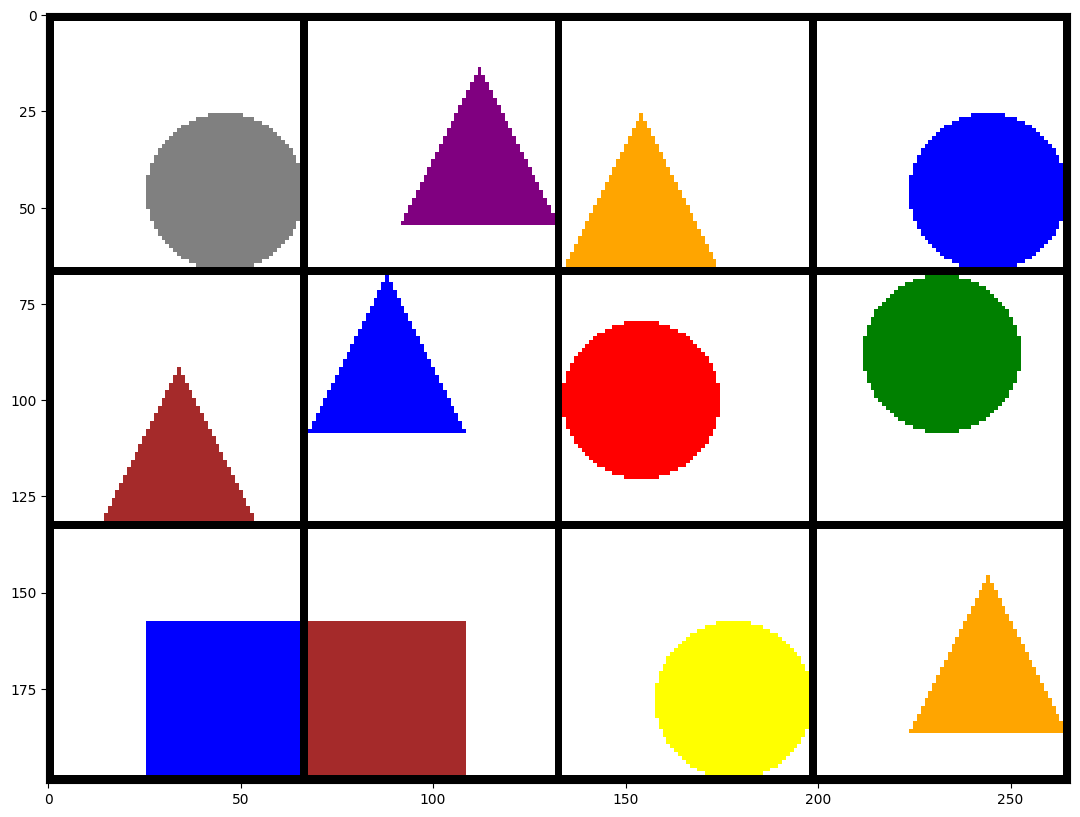

In [15]:
import torchvision

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0))) 

# **Encoder**

## **image-encoder**

In [16]:
#@title Image Encoder

class ImageEncoder(nn.Module):
    def __init__(self, embed_dim:int=EMBED_DIM):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.Conv2d(64,128,3,2,1),
            nn.ReLU(),
            nn.Conv2d(128,256,3,2,1),
            nn.ReLU()
        )

        self.projection = nn.Linear(256, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.convolutions(x)
        x = x.mean(dim=[2,3])
        x = self.projection(x)
        x = F.normalize(self.layernorm(x), dim=1)
        return x

## **text-encoder**

In [17]:
#@title Text Encoder

class TextEncoder(nn.Module):
    def __init__(self, vocab_size:int=VOCAB_SIZE, embed_dim:int=EMBED_DIM, context_window:int=caps_enc.shape[1], num_heads:int=ATTENTION_HEADS):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(context_window, embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, tokens):
        N, L = tokens.shape
        pos_emb_ids = torch.arange(L, device=tokens.device).unsqueeze(0).expand(N,L)
        pos_emb_vectors = self.position_embedding(pos_emb_ids)
        token_emb_vectors = self.token_embedding(tokens)
    
        x = pos_emb_vectors + token_emb_vectors  # (N, L, E)
        x = x.permute(1,0,2)                     
        x, _ = self.mha(x,x,x)                   
        x = x.permute(1,0,2)                    
    
        x = x[:, 0]                            
        x = self.projection(x)
        x = F.normalize(self.norm(x), dim=-1)
        return x

In [18]:
#@title Clip Loss

def clip_loss(img_emb, txt_emb, temperature=TEMPERATURE):
    img_emb = F.normalize(img_emb, dim=-1)
    txt_emb = F.normalize(txt_emb, dim=-1)

    logits = img_emb @ txt_emb.T / temperature # dot product
    targets = torch.arange(img_emb.size(0), device=img_emb.device)

    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.T, targets)

    return (loss_i + loss_t) / 2.0

In [19]:
img_encoder = ImageEncoder().to(device)
txt_encoder = TextEncoder().to(device)

In [20]:
params = list(img_encoder.parameters()) + list(txt_encoder.parameters())
optimizer = torch.optim.AdamW(params, lr=LR)

## **visualize-embedding**

In [21]:
def show_img(t, title=None):
    img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
    plt.figure(figsize=(2.2, 2.2))
    plt.axis('off')
    if title:
        plt.title(title, fontsize=8)
    _ = plt.imshow(img)
    plt.show()

In [22]:
print(type(shapes_ds[0]))
print(len(shapes_ds[0]))
print(shapes_ds[0][0].shape)
print(shapes_ds[0][1].shape)

sample_idx = 1

<class 'tuple'>
3
torch.Size([3, 64, 64])
torch.Size([4])


In [23]:
img_encoder.eval()
txt_encoder.eval()

with torch.no_grad():
    sample_img, sample_cap, sample_txt = shapes_ds[sample_idx]
    sample_img = sample_img.unsqueeze(0).to(device) #batch_dim
    sample_cap = sample_cap.unsqueeze(0).to(device)
    pre_train_img_embed = img_encoder(sample_img).squeeze(0).cpu().numpy()
    pre_train_cap_embed = txt_encoder(sample_cap).squeeze(0).cpu().numpy()

In [24]:
print(f"pre_train_img_embed.shape: {pre_train_img_embed.shape}")
print(f"pre_train_cap_embed.shape: {pre_train_cap_embed.shape}")

pre_train_img_embed.shape: (64,)
pre_train_cap_embed.shape: (64,)


red square center


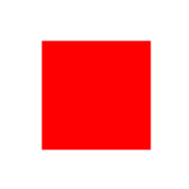

In [25]:
print(f"{sample_txt}")
show_img(sample_img.squeeze(0).cpu())

In [26]:
def plot_embedding(embedding, title=None):
    plt.figure(figsize=(8,1))
    plt.axis('off')
    if title:
        plt.title(title, fontsize=8)
    _ = plt.imshow(embedding.reshape(1,-1), aspect='auto', cmap='viridis')
    plt.show()

Cosine Similarity (dot product) before training: 0.0477


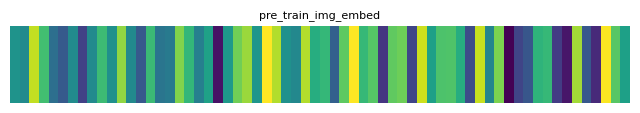

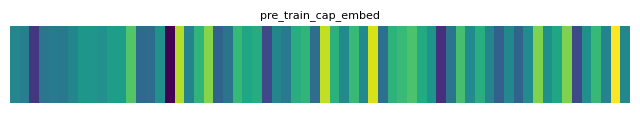

In [27]:
print(f"Cosine Similarity (dot product) before training: {np.dot(pre_train_img_embed, pre_train_cap_embed):.4f}")
plot_embedding(pre_train_img_embed, "pre_train_img_embed")
plot_embedding(pre_train_cap_embed, "pre_train_cap_embed")

In [28]:
def plot_3d(img_embed, txt_embed):
    """
    Plot first 3 dimensions of image & text embeddings as arrows from origin.
    """

    # Convert to numpy (supports torch tensors)
    img = np.asarray(img_embed)[:3]
    txt = np.asarray(txt_embed)[:3]

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    # Origin
    origin = np.zeros(3)

    # Plot arrows
    ax.quiver(*origin, *img, linewidth=2, color="blue")
    ax.quiver(*origin, *txt, linewidth=2, color="red")

    # Labels at arrow tips
    ax.text(*img, "Image", fontsize=10)
    ax.text(*txt, "Text", fontsize=10)

    # Axis labels
    ax.set_xlabel("Dim 0")
    ax.set_ylabel("Dim 1")
    ax.set_zlabel("Dim 2")

    # Make axes equal for better geometry
    max_val = np.max(np.abs([img, txt]))
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])
    ax.set_zlim([-max_val, max_val])

    plt.show()

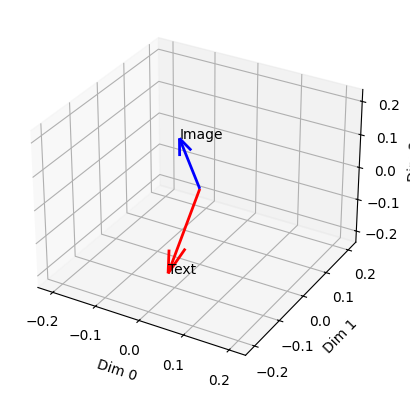

In [29]:
plot_3d(pre_train_img_embed, pre_train_cap_embed)

# **Train**

In [30]:
#@title Train

best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    # ---- train ----
    img_encoder.train(); txt_encoder.train()
    total, n = 0.0, 0
    
    for imgs, tokns, _ in train_loader:
        imgs, tokns = imgs.to(device), tokns.to(device)
        optimizer.zero_grad(set_to_none=True)
    
        ie = img_encoder(imgs)
        te = txt_encoder(tokns)
    
        loss = clip_loss(ie, te)
        loss.backward()
        optimizer.step()
    
        total += loss.item() * imgs.size(0)
        n += imgs.size(0)
    
    train_loss = total / n

    # ---- validation step ----
    img_encoder.eval(); txt_encoder.eval();

    val_total = 0.0
    with torch.no_grad():
        for imgs, tokns, _ in val_loader:
            imgs = imgs.to(device)
            tokns = tokns.to(device)

            ie = img_encoder(imgs)
            te = txt_encoder(tokns)

            loss = clip_loss(ie, te)
            val_total += loss.item() * imgs.size(0)

    val_loss = val_total / (len(val_loader) * BATCH_SIZE)

    print(f"Epoch {epoch:03d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

    # ---- save best model ----
    if val_loss < best_val:
        best_val = val_loss
        torch.save(
            {
                "img_encoder": img_encoder.state_dict(),
                "txt_encoder": txt_encoder.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "best_model.pt",
        )

Epoch 001 | train: 2.4755 | val: 1.8459
Epoch 002 | train: 2.0526 | val: 1.3404
Epoch 003 | train: 1.2841 | val: 0.7620
Epoch 004 | train: 0.6064 | val: 0.4480
Epoch 005 | train: 0.4423 | val: 0.4677
Epoch 006 | train: 0.2791 | val: 0.2867
Epoch 007 | train: 0.2253 | val: 0.1851
Epoch 008 | train: 0.1560 | val: 0.1812
Epoch 009 | train: 0.1786 | val: 0.2132
Epoch 010 | train: 0.1572 | val: 0.1579


# **Evaluate**

In [31]:
checkpoint = torch.load("/kaggle/working/best_model.pt", map_location=device)

img_encoder.load_state_dict(checkpoint["img_encoder"])
txt_encoder.load_state_dict(checkpoint["txt_encoder"])

<All keys matched successfully>

In [32]:
#@title Evaluation
img_encoder.eval()
txt_encoder.eval()

with torch.no_grad():
    sample_img, sample_cap, sample_txt = shapes_ds[sample_idx]
    sample_img = sample_img.unsqueeze(0).to(device) #batch_dim
    sample_cap = sample_cap.unsqueeze(0).to(device)
    post_train_img_embed = img_encoder(sample_img).squeeze(0).cpu().numpy()
    post_train_cap_embed = txt_encoder(sample_cap).squeeze(0).cpu().numpy()

Cosine Similarity (dot product) after training: 0.7775


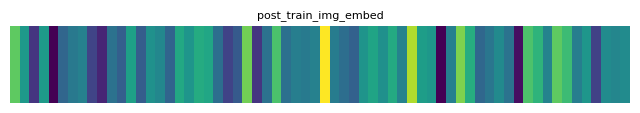

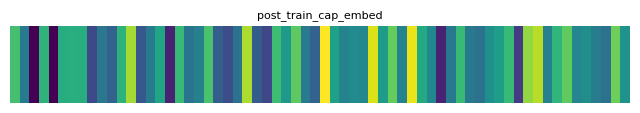

In [33]:
print(f"Cosine Similarity (dot product) after training: {np.dot(post_train_img_embed, post_train_cap_embed):.4f}")
plot_embedding(post_train_img_embed, "post_train_img_embed")
plot_embedding(post_train_cap_embed, "post_train_cap_embed")

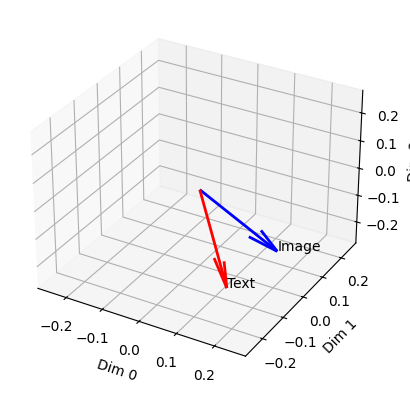

In [34]:
plot_3d(post_train_img_embed, post_train_cap_embed)